In [5]:
import pickle
import os
import igraph as ig
import pandas as pd
from matplotlib import pyplot as plt
import json

In [6]:
tmpl_dirpath = "../outputs/{major}_{kind_of_qa}_{postfix}"
majors = ["AM", "MCS", "DS"]
postfixes = ["hcmus_text-embedding-3-small"]
kinds_of_qa = ["closed_end"]

In [ ]:
total_graph_info = []
for major in majors:
    
    for postfix in postfixes:
        tmp = {
            "method": postfix,
        }
        for kind_of_qa in kinds_of_qa: 
            dirpath = tmpl_dirpath.format(major=major, kind_of_qa=kind_of_qa, postfix=postfix)
            if postfix == "hcmus_contriever":
                prefix = "facebook"
                graph_fpath = os.path.join(dirpath, f"gpt-4o-mini_{prefix}_{postfix.split('_')[-1]}/graph.pickle")
                entity_fpath = os.path.join(dirpath, f"gpt-4o-mini_{prefix}_{postfix.split('_')[-1]}/entity_embeddings/vdb_entity.parquet")
                chunk_fpath = os.path.join(dirpath, f"gpt-4o-mini_{prefix}_{postfix.split('_')[-1]}/chunk_embeddings/vdb_chunk.parquet")
            elif postfix == "hcmus_GritLM-7B":
                prefix = "GritLM"
                graph_fpath = os.path.join(dirpath, f"gpt-4o-mini_{prefix}_{postfix.split('_')[-1]}/graph.pickle")
                entity_fpath = os.path.join(dirpath, f"gpt-4o-mini_{prefix}_{postfix.split('_')[-1]}/entity_embeddings/vdb_entity.parquet")
                chunk_fpath = os.path.join(dirpath, f"gpt-4o-mini_{prefix}_{postfix.split('_')[-1]}/chunk_embeddings/vdb_chunk.parquet")
            elif postfix == "hcmus_NV-Embed-v2":
                prefix = "nvidia"
                graph_fpath = os.path.join(dirpath, f"gpt-4o-mini_{prefix}_{postfix.split('_')[-1]}/graph.pickle")
                entity_fpath = os.path.join(dirpath, f"gpt-4o-mini_{prefix}_{postfix.split('_')[-1]}/entity_embeddings/vdb_entity.parquet")
                chunk_fpath = os.path.join(dirpath, f"gpt-4o-mini_{prefix}_{postfix.split('_')[-1]}/chunk_embeddings/vdb_chunk.parquet")
            elif postfix == "hcmus_text-embedding-3-small":
                graph_fpath = os.path.join(dirpath, f"gpt-4o-mini_{postfix.split('_')[-1]}/graph.pickle")
                entity_fpath = os.path.join(dirpath, f"gpt-4o-mini_{postfix.split('_')[-1]}/entity_embeddings/vdb_entity.parquet")
                chunk_fpath = os.path.join(dirpath, f"gpt-4o-mini_{postfix.split('_')[-1]}/chunk_embeddings/vdb_chunk.parquet")
            else:
                raise ValueError(f"Unknown postfix: {postfix}")
            results_fpath = os.path.join(dirpath, "results.json")
            graph_info = json.load(open(results_fpath, "r"))["graph_info"]
            graph = pickle.load(open(graph_fpath, "rb"))
            entity_embeddings = pd.read_parquet(entity_fpath)
            chunk_embeddings = pd.read_parquet(chunk_fpath)
            # print(graph.ecount())
            # print(f"G")
            total_graph_info.append(
                {
                    f"{major}": graph_info
                }
            )
            ig.plot(
                graph,
                vertex_size=10,
                vertex_color='lightblue',
                edge_color='gray',
                # vertex_frame_color='white',  # Removes the border
                target=f'../results/graph_{major}.pdf'
            )

In [18]:
rows = []
for d in total_graph_info:
    for major, metrics in d.items():
        for metric, value in metrics.items():
            rows.append({'major': major, 'metric': metric, 'value': value})

df = pd.DataFrame(rows)
df

,major,metric,value
0,AM,num_phrase_nodes,1530
1,AM,num_passage_nodes,94
2,AM,num_total_nodes,1624
3,AM,num_extracted_triples,1904
4,AM,num_triples_with_passage_node,2037
5,AM,num_synonymy_triples,5065
6,AM,num_total_triples,9006
7,MCS,num_phrase_nodes,1531
8,MCS,num_passage_nodes,90
9,MCS,num_total_nodes,1621


In [48]:
selected_contents = [
    "advanced artificial intelligence",
    "nguyen thanh binh",
    "advanced research topics in data mining"
]
selected_hash_id = entity_embeddings[entity_embeddings["content"].isin(selected_contents)]["hash_id"].values
print(selected_hash_id)

['entity-73a9e3dd9d38966dbf7e752b485d9591'
 'entity-5804d5eecf9e855df656dd434bb5a91d'
 'entity-a3745716f642d1ebe3038fd59e0097ea']


In [73]:
subgraph.vs["content"]

['advanced artificial intelligence',
 'artificial intelligence',
 'elective course',
 'knowledge representation and reasoning',
 'mth10356',
 'nguyen thanh binh',
 'odd semester',
 'outcomes',
 'software agent',
 'solving problems by searching',
 'Course ID: MTH10356\nAdvanced Artificial Intelligence is a Elective course (ID: MTH10356) available in the odd semester. It is led by Nguyen Thanh Binh. Prerequisites: None. The course aims to deliver the following outcomes: This course will present topics in Artificial Intelligence (AI).  We will begin by defining the term "software agent” and discussing how software agents differ from programs in general.  We will then look at those problems in the field of AI that tend to receive the most attention.  Different researchers approach these problems differently.. Main content: This module includes the following topics:\nSolving Problems by Searching\nKnowledge Representation and Reasoning.']

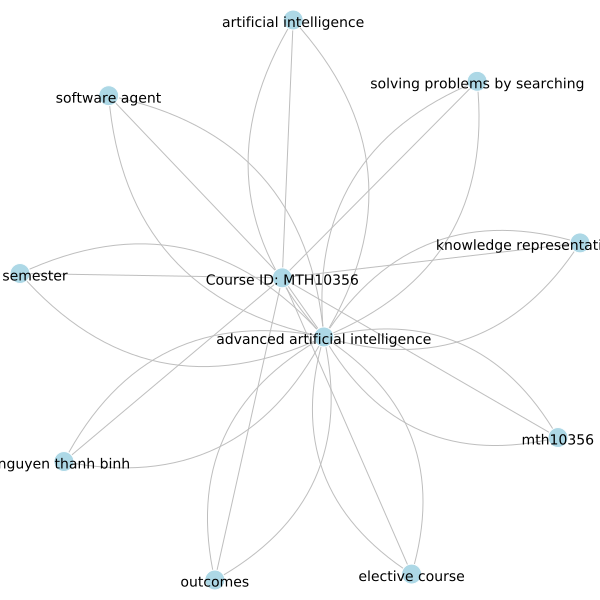

In [91]:
selected_index = graph.vs.find(name=selected_hash_id[0]).index

# Get the indices of the selected node and its neighbors
neighbor_indices = graph.neighborhood(selected_index, order=1)

# Create the subgraph containing the selected node and its neighbors
subgraph = graph.induced_subgraph(neighbor_indices)

## get text content of the subgraph
subgraph.vs["content"] = [graph.vs[i]["content"] for i in neighbor_indices]
subgraph.vs["name"] = [graph.vs[i]["name"] for i in neighbor_indices]

labels = [item.split("\n")[0] for item in subgraph.vs["content"]]

# fig, ax = plt.subplots(figsize=(8, 8))
# Visualize the subgraph
ig.plot(
    subgraph,
    vertex_label=labels,  # Show node names
    edge_label=subgraph.es["label"] if "label" in subgraph.es.attributes() else None,  # Show edge labels if available
    # vertex_size=5,
    target='../results/vis_graph_selected_node.pdf',
    vertex_color='lightblue',
    edge_color='gray',
    vertex_frame_color='white',  # Removes the border
    # target=ax
)
# plt.show()